## Group 33

- Alexandre Gonçalves (20240738)
- Bràulio Damba (20240007)
- João Henriques (20240499)
- Mariana Sousa (20240516)
- Victoria Goon (20240550)

### 1 - Mount and Imports

In [1]:
# source: https://stackoverflow.com/questions/48376580/how-to-read-data-in-google-colab-from-my-google-drive
# This code is required to your Google Drive to the Colab environment

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# We used the following to extract the  original dataset + dataset obtained after outlier manual removal from a zip file saved in our drive
# The zip file is located in the path "/content/drive/MyDrive/dataset/data.zip"
# source: https://stackoverflow.com/questions/38320290/how-to-extract-zip-file-in-google-colab

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data.zip" , "r")

zip_ref.extractall("/content/data")

zip_ref.close()

In [3]:
import os
import pandas as pd
import shutil

In [4]:
# Change the working directory to the correct folder. In the path below, the group member running the code saved the utils.py file and other required folders to run the code
os.chdir('/content/drive/MyDrive/Colab Notebooks')

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Colab Notebooks


In [5]:
from sklearn.model_selection import train_test_split


In [6]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from Library.utils import get_callbacks
from sklearn.metrics import classification_report

import tensorflow as tf

from keras.utils import image_dataset_from_directory
from keras.applications import VGG16, InceptionV3, ResNet50
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, F1Score, Precision, Recall


  # Image processing
from keras.utils import img_to_array, load_img
from keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomTranslation, RandomRotation, RandomContrast
  # Model
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
#from tensorflow_addons.metrics import F1Score
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.models import Model
from keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, Rescaling,
    RandomFlip, RandomRotation, RandomContrast, RandomTranslation
)
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.models import Sequential


#from Library.PreprocessingAugmentTemplate import Preprocessing_Augment_Template

### 2 - Dataset split

In [7]:
# Read metadata from source_images
metadata = pd.read_csv('/content/data/data/original/source_images/metadata.csv')

# Using stratify to maintain the distribution of classes in the train, validation, and test sets
train_df, val_test_df = train_test_split(metadata, test_size=0.3, stratify=metadata['family'], random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['family'], random_state=42)


In [8]:
# This function is used to move the images to implement the split defined above. After defining what images went to each set, we moved the images to the corresponding folders.

def move_images(df, folder_name, original_base_dir, target_base_dir):
    for _, row in df.iterrows():
        src_path = os.path.join(original_base_dir, row['file_path'])  # e.g., "arthropoda_apidae/image1.jpg"
        subfolder = os.path.dirname(row['file_path'])  # e.g., "arthropoda_apidae"
        dst_dir = os.path.join(target_base_dir, folder_name, subfolder)
        dst_path = os.path.join(dst_dir, os.path.basename(src_path))

        os.makedirs(dst_dir, exist_ok=True)

        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Missing file: {src_path}")

In [9]:
# Set the base directory for the original images (inside source images folder).
# Due to limited Google Drive storage for each group member, we couldn't permanently store in the drive the train, val, and test folders.
# As a result, we had to regenerate these datasets every time we ran the code, instead of saving them once for repeated use

original_base_dir = '/content/data/data/original/source_images'

# Set the base directory for the destination folders
target_base_dir = '/content/data/data/original'

# Create directories for each split
os.makedirs(os.path.join(target_base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'validation'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'test'), exist_ok=True)

# Move images to their corresponding folders
move_images(train_df, 'train', original_base_dir, target_base_dir)
move_images(val_df, 'validation', original_base_dir, target_base_dir)
move_images(test_df, 'test', original_base_dir, target_base_dir)

### 3 - Training

In [10]:
# Defining some of the parameters used in the model and to load the data
model_name = "Tang's_CNN"
epochs = 100
resolution = 224
batch_size = 64
n_classes = 202

In [11]:
# Load the image dataset in the train folder using a batch size of 64 and the resolution defined above
# we are also making sure that all images are in RGB format
# source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

train_data = image_dataset_from_directory(
    Path("/content/data/data/original/train"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 8388 files belonging to 202 classes.


In [12]:
# Load the image dataset in the validation folder using a batch size of 64 and the resolution defined above
# we are also making sure that all images are in RGB format
# source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

val_data = image_dataset_from_directory(
    Path("/content/data/data/original/validation"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 1797 files belonging to 202 classes.


In [13]:
# Load the image dataset in the test folder using a batch size of 64 and the resolution defined above
# we are also making sure that all images are in RGB format
# source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

test_data = image_dataset_from_directory(
    Path("/content/data/data/original/test"),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)

Found 1798 files belonging to 202 classes.


In [14]:
# Defining base line model architecture
# For the baseline model we used the following source: https://ieeexplore.ieee.org/document/7745199
# We decided to use Tang’s model architecture as a base since it had the best accuracy while being computationally efficient
# We adapted Tang’s CNN architecture to accommodate our dataset by increasing input resolution to 224×224 and modifying the model depth accordingly.
# These changes were necessary to capture fine-grained visual patterns relevant to phylum and family classification, while maintaining the simplicity and interpretability of a baseline model built from scratch.

def build_tang_cnn(input_shape, num_classes, optimizer='adam', metrics=['accuracy']):
    """
    Adapted Tang CNN for higher-resolution input (e.g., 224x224).

    Parameters:
        input_shape (tuple): Image shape (H, W, C)
        num_classes (int): Number of output classes
        optimizer (str or keras.optimizers.Optimizer)
        metrics (list): List of metrics for evaluation

    Returns:
        keras.Model: Compiled Keras model
    """

    # Augmentation + Preprocessing
    preprocess_block = Sequential(name="augmentation_pipeline")
    preprocess_block.add(Rescaling(1./255))
    # preprocess_block.add(RandomFlip("horizontal_and_vertical"))
    # preprocess_block.add(RandomRotation(0.15))
    # preprocess_block.add(RandomContrast(0.2))
    # preprocess_block.add(RandomTranslation(0.1, 0.1))

    input_tensor = Input(shape=input_shape, name="input_image")
    x = preprocess_block(input_tensor)

    # Deepened Tang architecture - We increased number of units inside each Convolutional layer to increase model capacity to deal with higher resolutions
    x = Conv2D(32, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)

    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)

    x = Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)

    x = Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)

    # Classification head
    # Flattening as per the default Tangs architeture after 224×224 input would create a huge number of parameters and risks overfitting. Hence we used GlobalAveragePooling2D
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    output_tensor = Dense(num_classes, activation='softmax', name="output_probs")(x)

    model = Model(inputs=input_tensor, outputs=output_tensor, name="TangCNN_Adapted")

    model.compile(
        optimizer=optimizer if isinstance(optimizer, str) else Adam(),
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model


In [15]:
# Selection of metrics to evaluate the model performance
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, f1_score, Precision(), Recall()]

# callbacks being used to monitor the model performance during training using the utils.py in the Library folder
callbacks = get_callbacks(
    base_dir="model_logs/" + model_name
)

In [16]:
# Define the optimizer, loss function and the model to run
optimizer = Adam(learning_rate=0.001, name="optimizer")

model = build_tang_cnn(input_shape = (resolution,resolution,3), num_classes = n_classes, optimizer=optimizer, metrics=metrics)

#loss = CategoricalCrossentropy(name="loss")

In [17]:
# model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [18]:
# Obtain the model summary
# The model summary is useful to understand the model architecture
# source: https://stackoverflow.com/questions/36946671/keras-model-summary-result-understanding-the-of-parameters
# source: https://keras.io/api/models/model/

model.summary()

Model: "TangCNN_Adapted"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_pipeline           │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probs (Dense)            │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 625,162 (2.38 MB)

 Trainable params: 625,162 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

In [20]:
# Training the model using the fit method
# The fit method is used to train the model on the training data and validate it on the validation data.
# source: https://keras.io/api/models/model_training_apis/
# source: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

result = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.0235 - f1_score: 0.0027 - loss: 5.1744 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: val_loss improved from inf to 5.01921, saving model to model_logs/Tang's_CNN/DL_confident_model_checkpoint_20250423_1559.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 54s 271ms/step - accuracy: 0.0235 - f1_score: 0.0027 - loss: 5.1740 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0401 - val_f1_score: 8.4677e-04 - val_loss: 5.0192 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 9.5000e-04
Epoch 2/100
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0328 - f1_score: 0.0021 - loss: 5.0358 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss improved from 5.01921 to 4.94425, saving model to model_logs/Tang's_CNN/DL_confident_model_checkpoint_20250423_1559.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - accuracy: 0.0329 - f1_score: 0.0021 - loss: 5.0354 - precision: 0.0000e+00 - rec

In [21]:
# Using model.evaluate to evaluate the model performance on the test set
# The results differ from the classification report below as it uses the metrics defined in the model.compile method and can be less accurate if:
# 1) Custom metrics (like F1Score) use streaming/batch-wise approximations or 2) Small test set or imbalanced batches.
# source: https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate

test_results = model.evaluate(
    test_data,
    return_dict=True,
    verbose=1
)

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.2020 - f1_score: 0.0891 - loss: 3.8015 - precision: 0.7263 - recall: 0.0830


In [22]:
# Classification report to evaluate the model performance with the performance per class and the overall performance
# Tends to give more precise results since it calculates exact metrics on the entire dataset at once (global view) using our manually predicted labels
# source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

y_true = []
y_pred = []
class_names = train_data.class_names

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Results

Test Loss: 3.8715085983276367
Test Accuracy: 0.1963292509317398


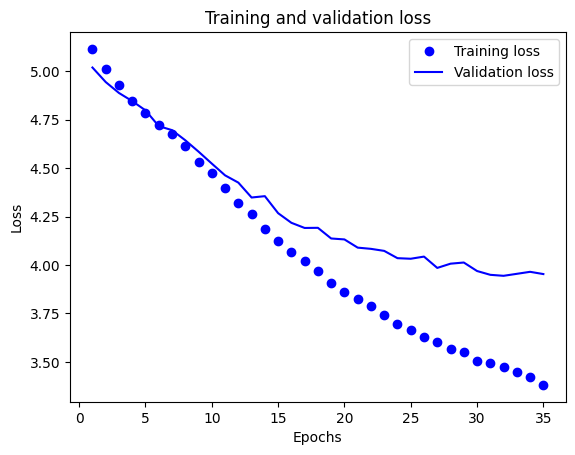

In [23]:
# Plot that compares the training and validation loss across training epochs
# The plot is useful to understand the model performance and if it is overfitting or underfitting

# Print evaluation results
print("Test Loss:", test_results['loss'])
print("Test Accuracy:", test_results['accuracy'])

# Step 3: Plot the loss
loss = result.history['loss']
val_loss = result.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()